In [ ]:
from google.colab import drive
drive.mount('/content/drive')
images_root =  '/content/drive/MyDrive/HVD_dataset/all_openrooms/main_xml'
labels_root =  '/content/drive/MyDrive/HVD_dataset/all_openrooms/labels_main_xml'

Mounted at /content/drive


In [ ]:
import os, re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

def create_image_label_mapping(images_root, labels_root, max_samples=750):
    mapping = []
    for folder in os.listdir(images_root):
        img_folder = os.path.join(images_root, folder)
        label_folder = os.path.join(labels_root, folder)
        if not os.path.isdir(img_folder) or not os.path.isdir(label_folder):
            continue
        for fname in os.listdir(img_folder):
            if fname.endswith(".png") and fname.startswith("im_"):
                match = re.match(r'im_(\d+)\.png', fname)
                if match:
                    img_id = match.group(1)
                    img_path = os.path.join(img_folder, fname)
                    label_path = os.path.join(label_folder, f"imsemLabel_{img_id}.npy")
                    if os.path.exists(label_path):
                        mapping.append((img_path, label_path))
                        if len(mapping) >= max_samples:
                            return mapping
    return mapping

mapping = create_image_label_mapping(images_root, labels_root)
print(f"Found {len(mapping)} samples")


Found 750 samples


In [ ]:
class ImageLabelDataset(Dataset):
    def __init__(self, mapping):
        self.mapping = mapping
        self.image_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])
        self.label_resize = transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST)

    def __len__(self):
        return len(self.mapping)

    def __getitem__(self, idx):
        img_path, label_path = self.mapping[idx]
        image = Image.open(img_path).convert("RGB")
        label = np.load(label_path)

        label = Image.fromarray(label.astype(np.uint8))
        label = self.label_resize(label)
        label = torch.from_numpy(np.array(label)).long()

        return self.image_transform(image), label


In [ ]:
def detect_num_classes(mapping, max_scan=100):
    classes = set()
    for _, label_path in mapping[:max_scan]:
        lbl = np.load(label_path)
        classes.update(np.unique(lbl).tolist())
    return max(classes) + 1


In [ ]:
class DenseNetSegmentation(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        densenet = models.densenet121(pretrained=True)
        self.encoder = densenet.features
        self.decoder = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2),  # 32 → 64
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2),  # 64 → 128
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2),  # 128 → 256
            nn.Conv2d(128, num_classes, kernel_size=1),
            nn.Upsample(scale_factor=0.5, mode='bilinear', align_corners=False)  # 256 → 128
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        return x


In [ ]:
def train_model(model, train_loader, val_loader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        total_loss, correct, total = 0, 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(out, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.numel()

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                out = model(imgs)
                loss = criterion(out, labels)
                val_loss += loss.item()
                preds = torch.argmax(out, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.numel()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * val_correct / val_total)

        print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.2f}% | "
              f"Val Loss: {val_losses[-1]:.4f}, Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
def plot_training_and_validation(train_losses, train_accs, val_losses, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs, val_losses, label="Val Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Accuracy", marker='o')
    plt.plot(epochs, val_accs, label="Val Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Pixel Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def visualize_predictions_overlay(model, dataset, class_names, num_samples=3, device='cuda'):
    model.eval()

    # Use consistent color map
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in range(len(class_names))]
    custom_cmap = ListedColormap(colors)

    for i in range(num_samples):
        image, true_mask = dataset[i]

        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            pred_mask = torch.argmax(output.squeeze(0), dim=0).cpu().numpy()

        image_np = image.permute(1, 2, 0).cpu().numpy()

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(image_np)
        axes[0].set_title("Input Image")
        axes[1].imshow(image_np)
        axes[1].imshow(pred_mask, cmap=custom_cmap, alpha=0.5)
        axes[1].set_title("Overlay: Prediction")
        axes[2].imshow(true_mask, cmap=custom_cmap)
        axes[2].set_title("Ground Truth")

        for ax in axes:
            ax.axis("off")

        # Add legend
        handles = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
        fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.02),
                   ncol=4, fontsize='small', frameon=False)

        plt.tight_layout()
        plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import colorsys

def visualize_predictions(model, dataset, class_names, num_samples=3, device='cuda'):
    model.eval()  # set model to evaluation mode
    # --- Create distinct color map for all classes ---
    N = len(class_names)
    colors = []
    for j in range(N):
        # generate color j by evenly spaced hue on [0,1)
        h = j / N
        l, s = 0.6, 0.9  # lightness and saturation for all colors
        rgb = colorsys.hls_to_rgb(h, l, s)
        colors.append(rgb)
    custom_cmap = ListedColormap(colors)

    # --- Display results for a few samples ---
    for i in range(num_samples):
        image, true_mask = dataset[i]
        # Run model prediction
        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            # If model outputs a structure with logits (e.g. from HuggingFace), handle that:
            logits = output.logits if hasattr(output, 'logits') else output
            pred_mask = torch.argmax(logits.squeeze(0), dim=0).cpu().numpy()
        # Prepare numpy image for plotting
        img_np = image.permute(1, 2, 0).cpu().numpy()

        # Plot four panels
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        # (a) Input image
        axes[0].imshow(img_np)
        axes[0].set_title("Input Image")
        axes[0].axis('off')
        # (b) Ground truth mask
        axes[1].imshow(true_mask.numpy(), cmap=custom_cmap)
        axes[1].set_title("Ground Truth")
        axes[1].axis('off')
        # (c) Prediction mask
        axes[2].imshow(pred_mask, cmap=custom_cmap)
        axes[2].set_title("Prediction Mask")
        axes[2].axis('off')
        # (d) Overlay of prediction on input
        axes[3].imshow(img_np)
        axes[3].imshow(pred_mask, cmap=custom_cmap, alpha=0.5)
        axes[3].set_title("Overlay on Input")
        axes[3].axis('off')

        # Optional: add a legend mapping class names to colors (for reference)
        handles = [mpatches.Patch(color=colors[j], label=class_names[j]) for j in range(N)]
        fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.05),
                   ncol=6, fontsize='small', frameon=False)
        plt.tight_layout()
        plt.show()


In [ ]:
# Load mapping
mapping = create_image_label_mapping(images_root, labels_root, max_samples=750)
num_classes = detect_num_classes(mapping)


In [ ]:
model = DenseNetSegmentation(num_classes)
dataset = ImageLabelDataset(mapping)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 87.8MB/s]


Epoch 1 | Train Loss: 1.9699, Acc: 48.60% | Val Loss: 1.5602, Acc: 55.02%
Epoch 2 | Train Loss: 1.5081, Acc: 55.43% | Val Loss: 1.4131, Acc: 58.54%
Epoch 3 | Train Loss: 1.3397, Acc: 58.79% | Val Loss: 1.4129, Acc: 59.26%
Epoch 4 | Train Loss: 1.2418, Acc: 62.10% | Val Loss: 1.2659, Acc: 61.75%
Epoch 5 | Train Loss: 1.1195, Acc: 63.95% | Val Loss: 1.2040, Acc: 62.69%
Epoch 6 | Train Loss: 0.9905, Acc: 67.48% | Val Loss: 1.0844, Acc: 65.55%
Epoch 7 | Train Loss: 0.9091, Acc: 70.27% | Val Loss: 1.1067, Acc: 65.11%
Epoch 8 | Train Loss: 0.9395, Acc: 69.24% | Val Loss: 1.0841, Acc: 67.26%
Epoch 9 | Train Loss: 0.8013, Acc: 73.54% | Val Loss: 1.0233, Acc: 67.80%
Epoch 10 | Train Loss: 0.7781, Acc: 74.23% | Val Loss: 0.9954, Acc: 67.67%
Epoch 11 | Train Loss: 0.6690, Acc: 77.05% | Val Loss: 0.8669, Acc: 72.09%
Epoch 12 | Train Loss: 0.5720, Acc: 80.21% | Val Loss: 0.8336, Acc: 72.40%
Epoch 13 | Train Loss: 0.5151, Acc: 81.78% | Val Loss: 0.8411, Acc: 73.58%
Epoch 14 | Train Loss: 0.4543, Acc

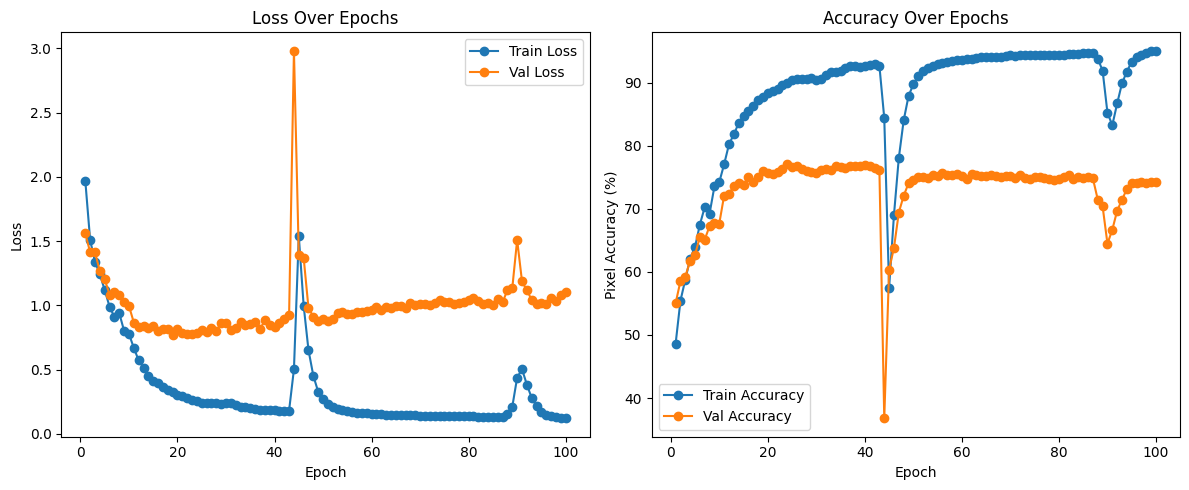

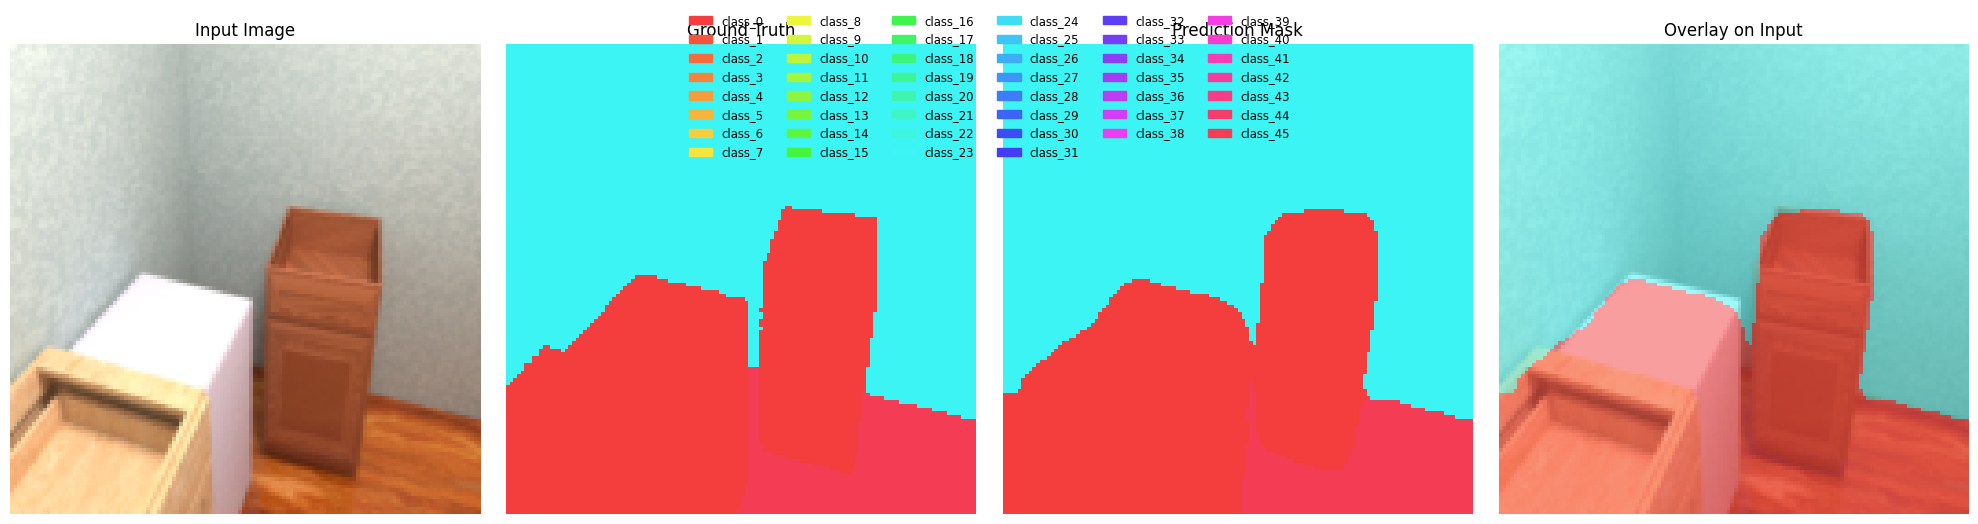

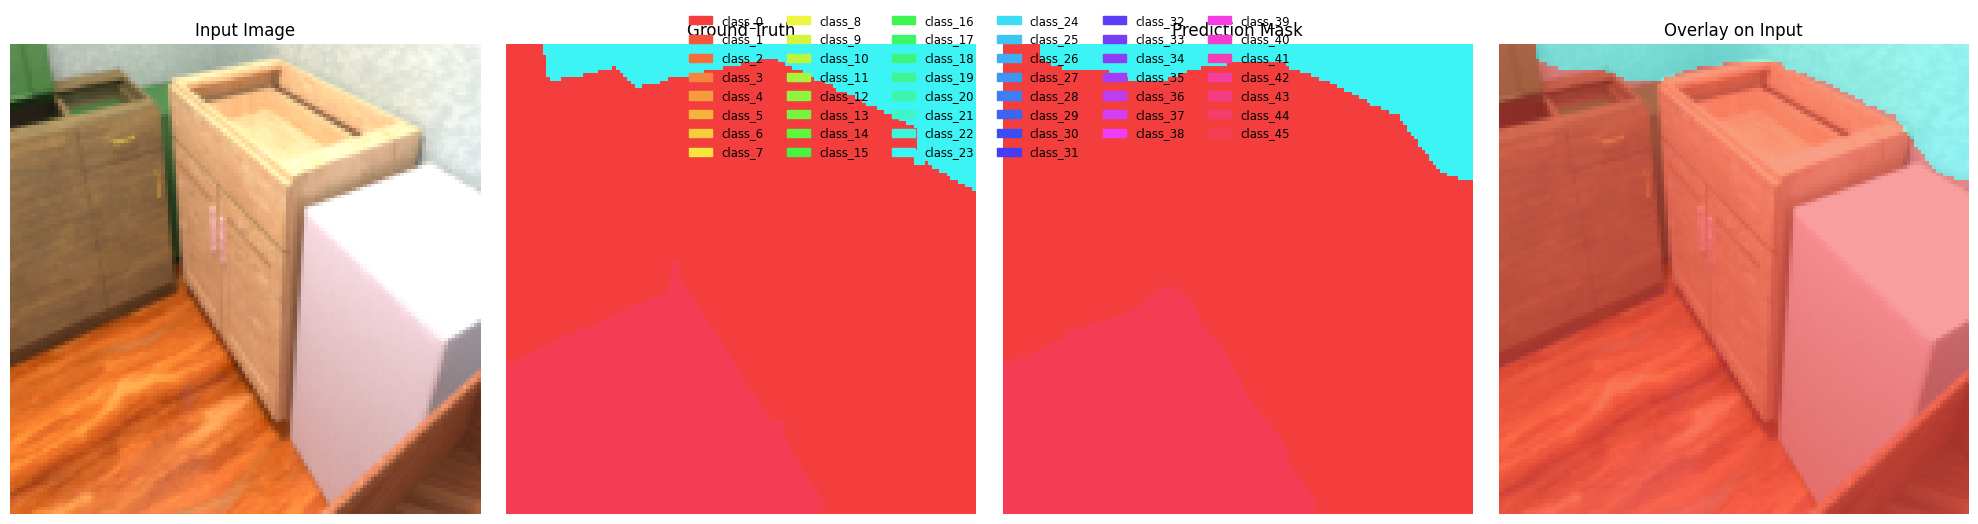

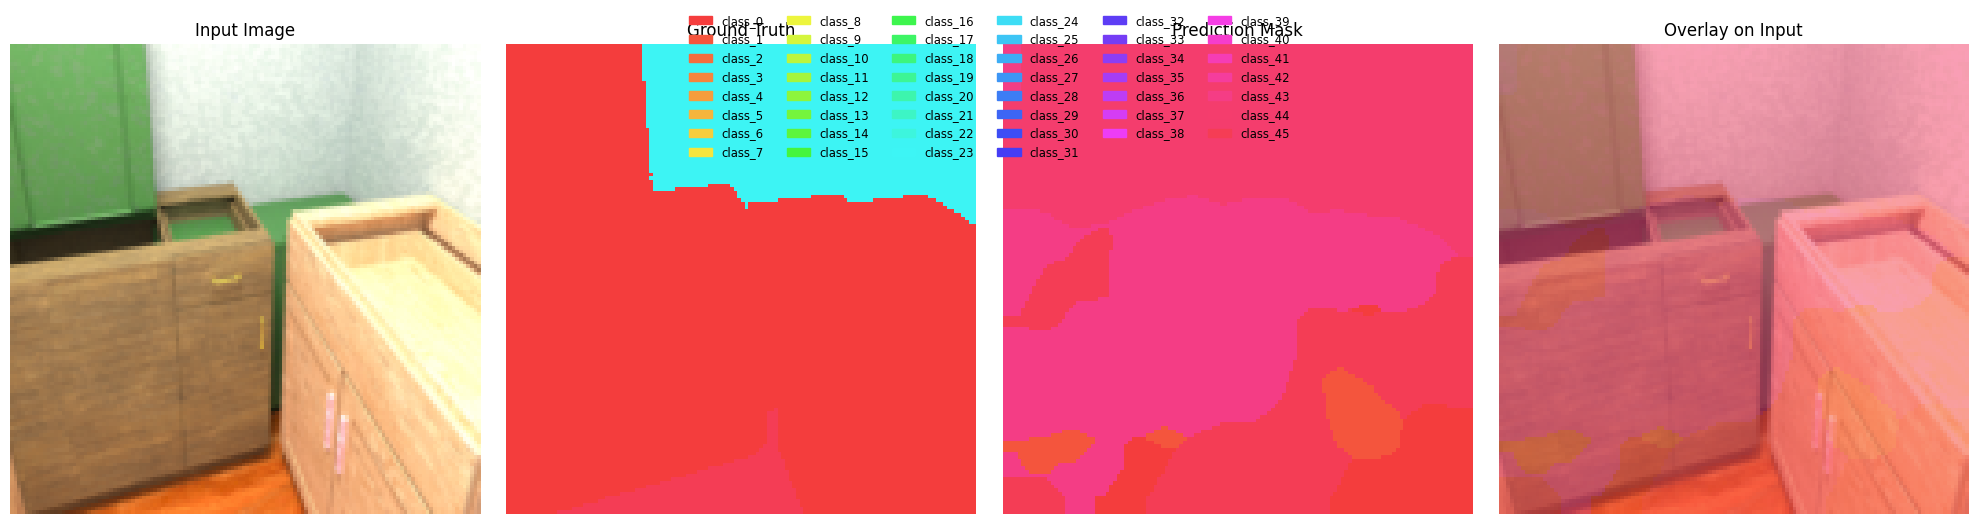

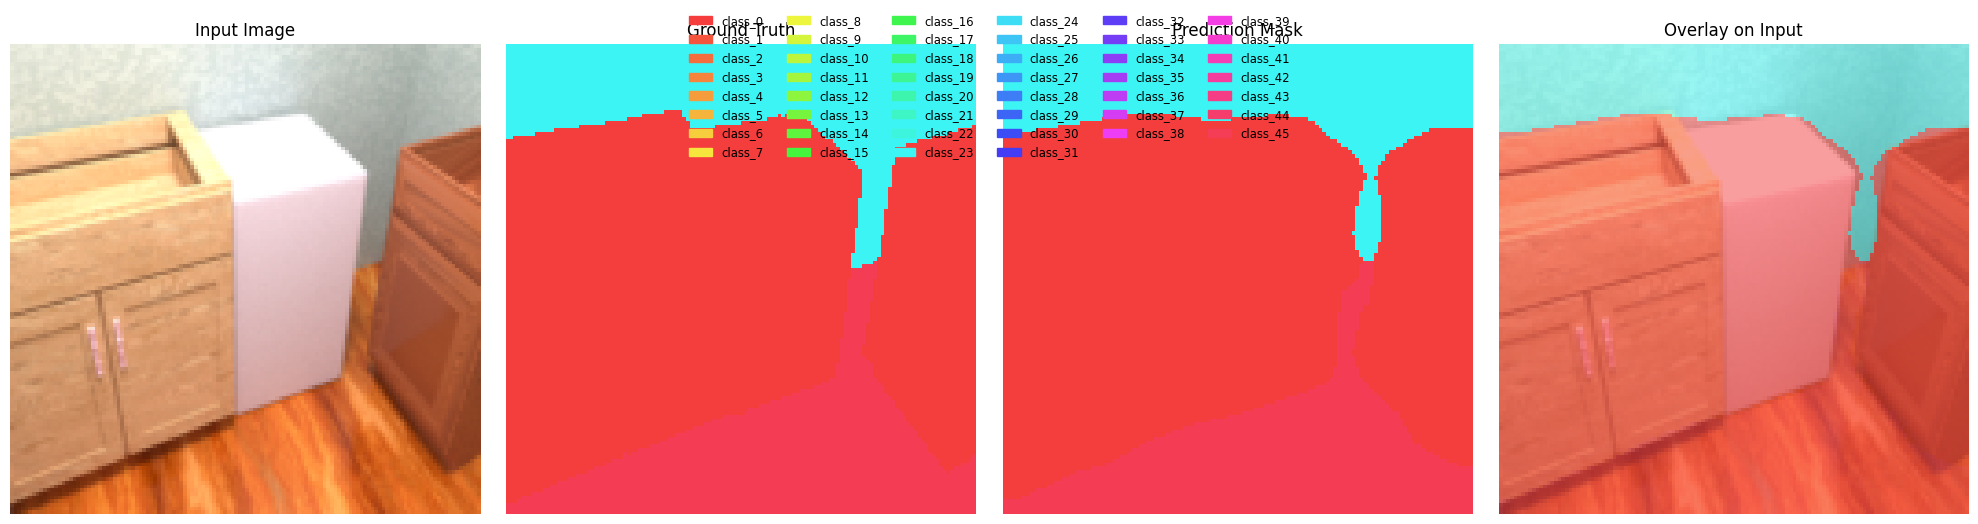

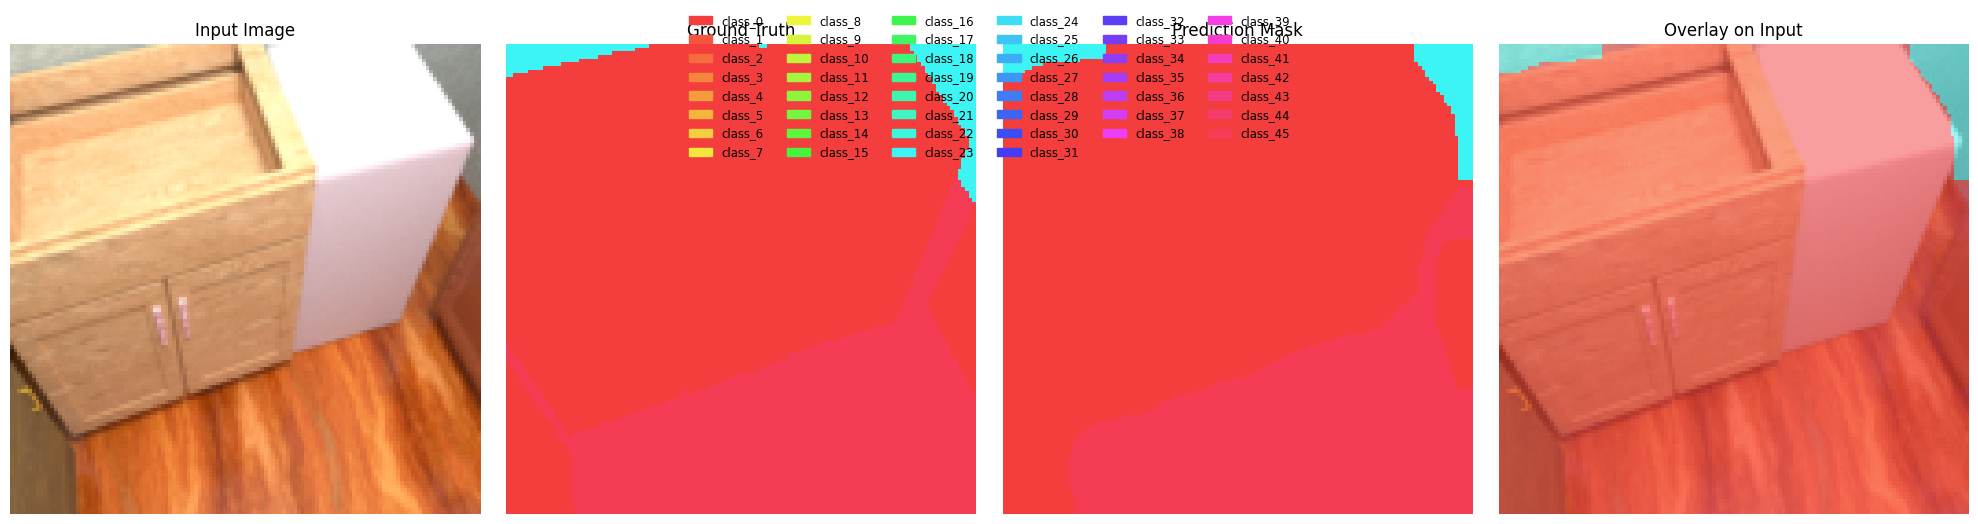

In [ ]:
# Load mapping
mapping = create_image_label_mapping(images_root, labels_root, max_samples=750)
num_classes = detect_num_classes(mapping)

# Create dataset and split
dataset = ImageLabelDataset(mapping)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Initialize and train model
model = DenseNetSegmentation(num_classes)
train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader, epochs=100)

# Plot results
plot_training_and_validation(train_losses, train_accs, val_losses, val_accs)
class_names = [f"class_{i}" for i in range(num_classes)]
visualize_predictions(model, dataset, class_names, num_samples=5, device=device)


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def grad_cam_segmentation(model, image_tensor, target_class, device='cuda'):
    model.eval()
    x = image_tensor.unsqueeze(0).to(device)  # [1,3,H,W]

    # 1) Hook to grab activations
    activations = {}
    def forward_hook(module, inp, out):
        activations['feat'] = out
    handle = model.encoder[-1].register_forward_hook(forward_hook)

    # 2) Forward pass
    outputs = model(x)
    logits  = outputs.logits if hasattr(outputs, 'logits') else outputs
    pred_mask = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

    # 3) Build score for target class
    mask = (pred_mask == target_class).astype(np.float32)          # [H,W]
    mask_tensor = torch.from_numpy(mask).to(device).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    class_logits = logits[:, target_class:target_class+1, :, :]    # [1,1,H,W]
    score = (class_logits * mask_tensor).sum()

    # 4) Compute gradients w.r.t. activations
    grads = torch.autograd.grad(score, activations['feat'], retain_graph=False)[0]  # [1,C,h,w]
    handle.remove()

    # 5) Pool gradients and weight activations
    pooled_grads = grads.mean(dim=[0,2,3])  # [C]
    feat = activations['feat'][0]          # [C,h,w]
    for i, w in enumerate(pooled_grads):
        feat[i] *= w

    # 6) Build CAM
    cam = feat.sum(dim=0)                  # [h,w]
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-6)

    # 7) Detach before converting to numpy
    cam_np = cam.detach().cpu().numpy()

    return cam_np, pred_mask

def show_gradcam_overlay(image_tensor, cam, pred_mask, class_id):
    """
    image_tensor: [3,H,W] CPU tensor
    cam: [h,w] numpy array
    pred_mask: [H,W] numpy array
    """
    img_np = image_tensor.permute(1,2,0).cpu().numpy()

    # Upsample CAM to image size
    cam_img = Image.fromarray((cam * 255).astype(np.uint8)).resize(
        (img_np.shape[1], img_np.shape[0]), Image.BILINEAR
    )
    cam_np = np.array(cam_img) / 255.0

    fig, axs = plt.subplots(1,3,figsize=(15,5))
    axs[0].imshow(img_np)
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    axs[1].imshow(img_np)
    axs[1].imshow(cam_np, cmap="jet", alpha=0.4)
    axs[1].set_title(f"Grad-CAM (class {class_id})")
    axs[1].axis("off")

    axs[2].imshow(pred_mask, cmap="tab20")
    axs[2].set_title("Model Prediction")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


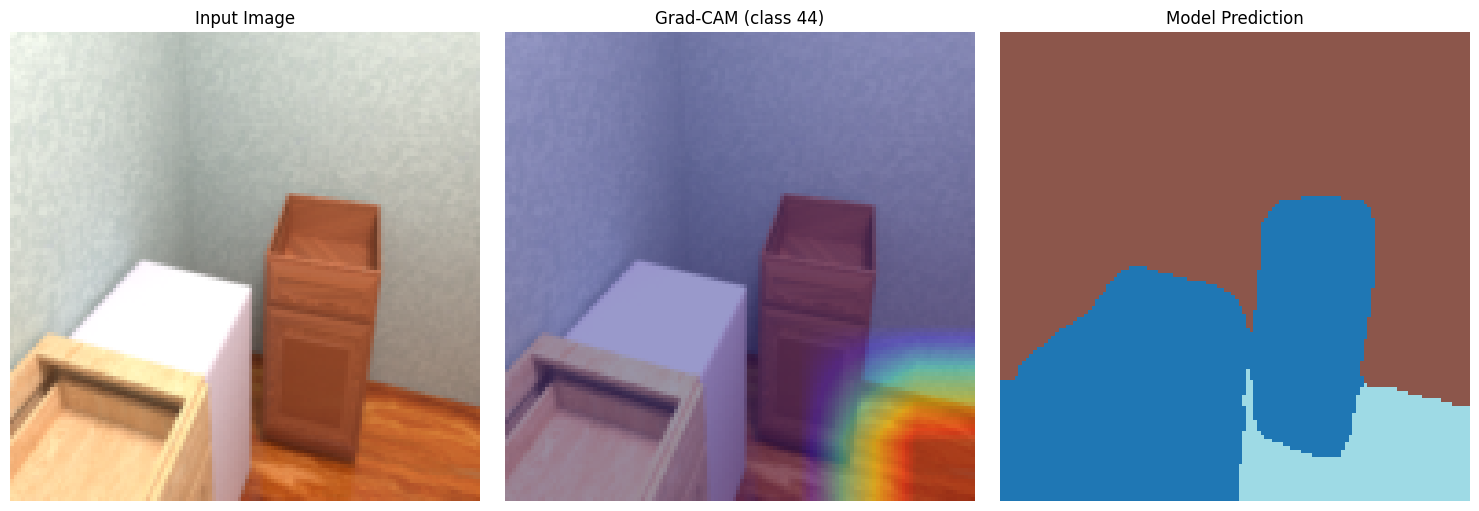

In [ ]:
# get a sample
image_tensor, _ = dataset[0]             # your ImageLabelDataset
target_class    = 44                  # class ID to visualize

# compute Grad-CAM
cam, pred_mask = grad_cam_segmentation(
    model=model,
    image_tensor=image_tensor,
    target_class=target_class,
    device=device
)

# display
show_gradcam_overlay(
    image_tensor=image_tensor,
    cam=cam,
    pred_mask=pred_mask,
    class_id=target_class
)


In [ ]:
import math

def visualize_all_gradcams(model, dataset, index=0, device='cuda'):
    """
    For the sample at `dataset[index]`, compute and display Grad-CAM heatmaps
    for every class ID present in its ground-truth label mask.
    """
    # 1) grab the sample
    image_tensor, label = dataset[index]            # image_tensor: [3,H,W], label: [H,W]
    image_np = image_tensor.permute(1,2,0).cpu().numpy()

    # 2) find all class IDs in this mask
    class_ids = np.unique(label.cpu().numpy()).tolist()
    n = len(class_ids)

    # 3) prepare grid
    cols = min(4, n)
    rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten()

    # 4) compute & plot each
    for ax, cls in zip(axes, class_ids):
        cam, pred_mask = grad_cam_segmentation(
            model=model,
            image_tensor=image_tensor,
            target_class=int(cls),
            device=device
        )
        # upsample cam to image size
        cam_img = Image.fromarray((cam*255).astype(np.uint8)).resize(
            (image_np.shape[1], image_np.shape[0]), Image.BILINEAR
        )
        heat_np = np.array(cam_img)/255.0

        ax.imshow(image_np)
        ax.imshow(heat_np, cmap='jet', alpha=0.4)
        ax.set_title(f"Class {cls}")
        ax.axis('off')

    # 5) turn off any extra axes
    for ax in axes[n:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


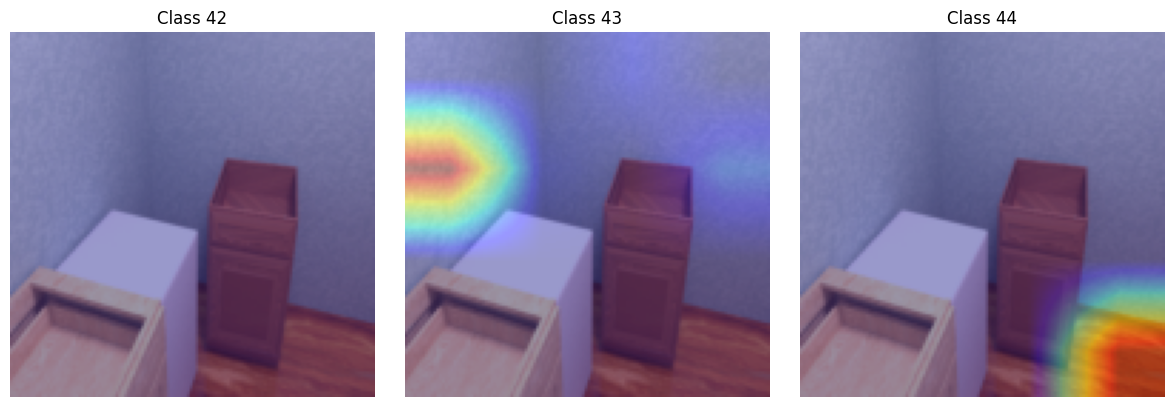

In [ ]:
# Make sure grad_cam_segmentation() is defined as before
# and `dataset` is your ImageLabelDataset or similar.

visualize_all_gradcams(
    model=model,
    dataset=dataset,
    index=0,       # which sample to visualize
    device=device  # "cuda" or "cpu"
)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def compare_prediction_vs_truth(image_tensor, cam, pred_mask, true_label, class_id):
    """
    image_tensor: [3,H,W] CPU torch tensor
    cam:         [h,w] numpy array heatmap in [0,1]
    pred_mask:   [H,W] numpy array of predicted class IDs
    true_label:  [H,W] torch tensor of ground-truth class IDs
    class_id:    int, the class we’re inspecting
    """
    img_np = image_tensor.permute(1,2,0).cpu().numpy()
    H, W = img_np.shape[:2]

    # Resize cam → full image
    from PIL import Image
    cam_img = Image.fromarray((cam*255).astype(np.uint8)).resize((W,H), Image.BILINEAR)
    cam_np  = np.array(cam_img)/255.0

    # Build binary masks for class_id
    pred_bin = (pred_mask == class_id)
    true_bin = (true_label.cpu().numpy() == class_id)

    fig, axes = plt.subplots(1,4,figsize=(16,4))
    axes[0].imshow(img_np);        axes[0].set_title("Image");       axes[0].axis('off')
    axes[1].imshow(img_np); axes[1].imshow(cam_np, cmap='jet', alpha=0.4)
    axes[1].set_title(f"Grad-CAM for class {class_id}"); axes[1].axis('off')
    axes[2].imshow(pred_bin, cmap='gray'); axes[2].set_title("Predicted Mask"); axes[2].axis('off')
    axes[3].imshow(true_bin, cmap='gray'); axes[3].set_title("Ground-Truth Mask"); axes[3].axis('off')
    plt.tight_layout()
    plt.show()


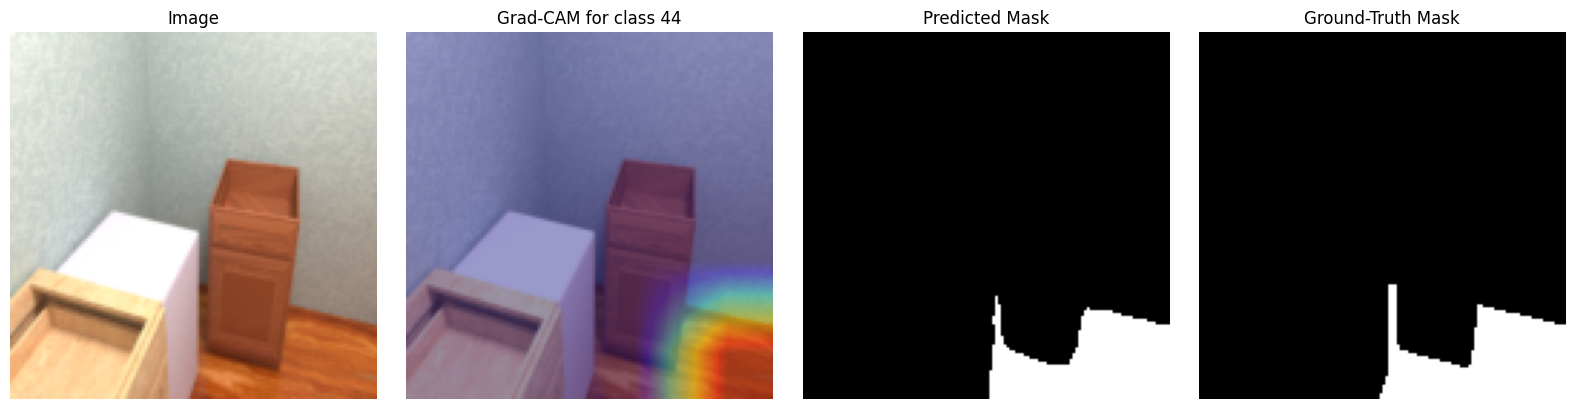

In [ ]:
# pick a sample and class
idx = 0
class_id = 44

# 1) Grab the sample properly
image_tensor, true_label = dataset[idx]

# 2) Call without unpacking the label
cam, pred_mask = grad_cam_segmentation(
    model=model,
    image_tensor=image_tensor,
    target_class=class_id,
    device=device
)
compare_prediction_vs_truth(
    image_tensor=image_tensor,
    cam=cam,
    pred_mask=pred_mask,
    true_label=true_label,
    class_id=class_id
)


In [ ]:
import numpy as np

def iou_for_class(pred_mask, true_label, class_id):
    pred_bin = (pred_mask == class_id)
    true_bin = (true_label.cpu().numpy() == class_id)
    intersection = np.logical_and(pred_bin, true_bin).sum()
    union        = np.logical_or (pred_bin, true_bin).sum()
    if union == 0:
        return float('N/a')   # class not present
    return intersection / union

# Example:
iou42 = iou_for_class(pred_mask, dataset[idx][1], class_id=42)
print(f"IoU for class 42: {iou42:.3f}")
iou43 = iou_for_class(pred_mask, dataset[idx][1], class_id=43)
print(f"IoU for class 43: {iou42:.3f}")
iou44 = iou_for_class(pred_mask, dataset[idx][1], class_id=44)
print(f"IoU for class 44: {iou42:.3f}")

IoU for class 42: 0.952
IoU for class 43: 0.952
IoU for class 44: 0.952
